In [80]:
import sys
sys.path.insert(0, '/home/workspace/mm_analysis')
sys.path.insert(0, '/home/workspace/')

from py_util import *
from utilities import *

hdir = '/home/workspace'
wdir = hdir + "/mm_analysis/EXP-01244"
pltdir = wdir + "/plots/"
objdir = wdir + "/objects/"
degdir = wdir + "/deg_list/"

raw_adata = sc.read_h5ad(hdir + '/mm_analysis/EXP-01244/rerun_objects/raw_adata.h5ad')
raw_p_adata = sc.read_h5ad(hdir + '/mm_analysis/EXP-01244/rerun_objects/raw_processed_adata.h5ad')
adata = sc.read_h5ad(hdir + '/mm_analysis/EXP-01244/rerun_objects/adata.h5ad')

# Processing adata

Filtering: Using a permissive filtering parameter to capture as much real biology.

- most filtering occurs from pct_counts_mt using filtering parameters from Single Cell Best Practices
    - median pct_counts_mt is 0.05%, and goes up to 15% (using 5% as filtering threshold)

In [145]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M)
    
    return outlier


def process_h5s(cr_outs_path):

    # Dictionary mapping user-friendly sample names to their corresponding IDs
    sample_dict = {
       'week2': "OR07965-01",     # Maps time point labels to sample IDs
       'week3': "OR07965-02", 
       'week4': "OR00001",
       'bm': "BMC07965-007",      # Bone marrow sample
       'msc': "CELL00911"         # Mesenchymal stem cell sample
    }

    name_dict = {
       'week2': "Week 2",
       'week3': "Week 3", 
       'week4': "Week 4",
       'bm': "BMMC Start Sample",
       'msc': "MSC Start Sample"   
    }
    
    # Create reverse mapping from sample IDs to their user-friendly names
    id_to_sample = {v: k for k, v in sample_dict.items()}
    
    # Find all filtered_feature_bc_matrix.h5 files in the directory structure
    h5_paths = [os.path.join(root, 'sample_filtered_feature_bc_matrix.h5') 
               for root, _, files in os.walk(cr_outs_path) 
               if 'sample_filtered_feature_bc_matrix.h5' in files]
    
    # Dictionary to store AnnData objects for each sample
    adatas = {}
    
    # Process each H5 file
    for path in h5_paths:
        # Extract sample name from path (e.g., 'BMC07965-007_3')
        name = path.split('per_sample_outs/')[1].split('/')[0]
        
        # Read the H5 file and create AnnData object
        adata = sc.read_10x_h5(path)
        adata.var_names_make_unique()

        adata.var["mt"] = adata.var_names.str.startswith("MT-")                 # mitochondrial genes
        adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
        adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes

        sc.pp.calculate_qc_metrics(
            adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
        )
        
        adata.obs["outlier"] = (
            is_outlier(adata, "log1p_total_counts", 5)
            | is_outlier(adata, "log1p_n_genes_by_counts", 5)
            | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
        )
        
        adata.obs["mt_outlier"] = adata.obs["pct_counts_mt"] > 5        # Adjusted pct_counts_mt to 5%

        # Run Scrublet for doublet detection
        scrub = scrublet.Scrublet(adata.X)
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)

        # Add Scrublet results to cell metadata
        adata.obs['doublet_score'] = doublet_scores
        adata.obs['predicted_doublet'] = predicted_doublets
        
        print(f"Total number of cells: {adata.n_obs}")
        adata = adata[adata.obs["predicted_doublet"] == False].copy()
        adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
        print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
        
        # Store raw counts
        adata.layers["counts"] = adata.X.copy()

        adatas[name] = adata

    # Combine all samples into one AnnData object
    concat = ad.concat(adatas, label='sample', join='outer', merge='same')

    concat.obs['base_sample'] = concat.obs['sample'].str.replace(r'_\d+$', '', regex=True)      # Add metadata column for batched replicates
    concat.obs['sample_type'] = concat.obs['base_sample'].replace(id_to_sample)                 # Add sample names (week2, week3, etc.)
    concat.obs['name'] = concat.obs['sample_type'].replace(name_dict)                           # Add pretty names (Week 2, Week 3, etc.)

    return concat


def process_groups(raw_adata, file_path=None, nmad=5):

    if file_path is not None:
        adata = process_h5s(file_path)
    else:
        adata = raw_adata
    
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    
    # Logarithmize the data
    sc.pp.log1p(adata)

    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)

    # Save raw
    adata.raw = adata
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    # Scale the data
    sc.pp.scale(adata, max_value=10, zero_center=False)

    # Perform PCA
    sc.tl.pca(adata, svd_solver='arpack')

    # Harmonizing data based on sample type
    X = adata.obsm['X_pca'].astype(np.float64)
    harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')
    adata.obsm['X_pca'] = harmony_out.Z_corr.T

    # Compute neighbors and UMAP
    sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca', n_pcs=20)
    sc.tl.umap(adata, min_dist=0.45, random_state=0, n_components=2)

    # Computing a range of leiden resolutions from 0-2 in increments of 0.1
    res_range = np.round(np.arange(0, 2.2, 0.1), 1)
    for res in res_range:
        sc.tl.leiden(
            adata, 
            flavor="igraph",
            key_added=f"leiden_{str(res).replace('.', '_')}",
            n_iterations=2,
            resolution=res
        )

    # # Calculating 
    # sc.tl.paga(adata, groups='leiden_0_9')

    # # Using leiden resolution 0.9 since it seems to show stable level 1 celltypes
    # sc.tl.rank_genes_groups(adata, 'leiden_0_9', method='t-test', key_added="t-test")
    
    return adata

In [130]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M)
    
    return outlier


def process_h5s(cr_outs_path):

    # Dictionary mapping user-friendly sample names to their corresponding IDs
    sample_dict = {
       'week2': "OR07965-01",     # Maps time point labels to sample IDs
       'week3': "OR07965-02", 
       'week4': "OR00001",
       'bm': "BMC07965-007",      # Bone marrow sample
       'msc': "CELL00911"         # Mesenchymal stem cell sample
    }

    name_dict = {
       'week2': "Week 2",
       'week3': "Week 3", 
       'week4': "Week 4",
       'bm': "BMMC Start Sample",
       'msc': "MSC Start Sample"   
    }
    
    # Create reverse mapping from sample IDs to their user-friendly names
    id_to_sample = {v: k for k, v in sample_dict.items()}
    
    # Find all filtered_feature_bc_matrix.h5 files in the directory structure
    h5_paths = [os.path.join(root, 'sample_filtered_feature_bc_matrix.h5') 
               for root, _, files in os.walk(cr_outs_path) 
               if 'sample_filtered_feature_bc_matrix.h5' in files]
    
    # Dictionary to store AnnData objects for each sample
    adatas = {}
    
    # Process each H5 file
    for path in h5_paths:
        # Extract sample name from path (e.g., 'BMC07965-007_3')
        name = path.split('per_sample_outs/')[1].split('/')[0]
        
        # Read the H5 file and create AnnData object
        adata = sc.read_10x_h5(path)
        adata.var_names_make_unique()
        adatas[name] = adata
        
        # Run Scrublet for doublet detection
        scrub = scrublet.Scrublet(adata.X)
        doublet_scores, predicted_doublets = scrub.scrub_doublets(verbose=False)

        # Add Scrublet results to cell metadata
        adata.obs['doublet_score'] = doublet_scores
        adata.obs['predicted_doublet'] = predicted_doublets

    # Combine all samples into one AnnData object
    concat = ad.concat(adatas, label='sample', join='outer', merge='same')

    concat.obs['base_sample'] = concat.obs['sample'].str.replace(r'_\d+$', '', regex=True)      # Add metadata column for batched replicates
    concat.obs['sample_type'] = concat.obs['base_sample'].replace(id_to_sample)                 # Add sample names (week2, week3, etc.)
    concat.obs['name'] = concat.obs['sample_type'].replace(name_dict)                           # Add pretty names (Week 2, Week 3, etc.)

    return concat


def process_groups(raw_adata, file_path=None):

    if file_path is not None:
        adata = process_h5s(file_path)
    else:
        adata = raw_adata
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")                 # mitochondrial genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes

    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )
    
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    
    adata.obs["mt_outlier"] = adata.obs["pct_counts_mt"] > 5        # Adjusted pct_counts_mt to 5%
    
    print(f"Total number of cells: {adata.n_obs}")
    adata = adata[adata.obs["predicted_doublet"] == False].copy()
    adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    
    print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    
    # Store raw counts
    adata.layers["counts"] = adata.X.copy()
    
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    
    # Logarithmize the data
    sc.pp.log1p(adata)

    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)

    # Save raw
    adata.raw = adata
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()

    # Scale the data
    sc.pp.scale(adata, max_value=10, zero_center=False)

    # Perform PCA
    sc.tl.pca(adata, svd_solver='arpack')

    # Harmonizing data based on sample type
    X = adata.obsm['X_pca'].astype(np.float64)
    harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')
    adata.obsm['X_pca'] = harmony_out.Z_corr.T

    # Compute neighbors and UMAP
    sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca', n_pcs=20)
    sc.tl.umap(adata, min_dist=0.45, random_state=0, n_components=2)

    # Computing a range of leiden resolutions from 0-2 in increments of 0.1
    res_range = np.round(np.arange(0, 2.2, 0.1), 1)
    for res in res_range:
        sc.tl.leiden(
            adata, 
            flavor="igraph",
            key_added=f"leiden_{str(res).replace('.', '_')}",
            n_iterations=2,
            resolution=res
        )

    # # Calculating 
    # sc.tl.paga(adata, groups='leiden_0_9')

    # # Using leiden resolution 0.9 since it seems to show stable level 1 celltypes
    # sc.tl.rank_genes_groups(adata, 'leiden_0_9', method='t-test', key_added="t-test")
    
    return adata

In [146]:
cr_outs_path = os.path.join(hdir, "mm_analysis/EXP-01244/data/EXP-01244_cr_outs")

# raw_adata = process_h5s(cr_outs_path)
adata = process_groups(file_path=cr_outs_path, raw_adata=None)

# raw_adata.write(wdir + '/rerun_objects/raw_adata.h5ad', compression='gzip')
adata.write(wdir + '/rerun_objects/adata.h5ad', compression='gzip')

Total number of cells: 3959
Number of cells after filtering of low quality cells: 3805
Total number of cells: 8690
Number of cells after filtering of low quality cells: 8515
Total number of cells: 651
Number of cells after filtering of low quality cells: 514
Total number of cells: 7843
Number of cells after filtering of low quality cells: 7636
Total number of cells: 2616
Number of cells after filtering of low quality cells: 2535
Total number of cells: 1092
Number of cells after filtering of low quality cells: 1070
Total number of cells: 1205
Number of cells after filtering of low quality cells: 998
Total number of cells: 3546
Number of cells after filtering of low quality cells: 3420
Total number of cells: 10158
Number of cells after filtering of low quality cells: 9918
Total number of cells: 551
Number of cells after filtering of low quality cells: 388
Total number of cells: 9124
Number of cells after filtering of low quality cells: 9056


2025-02-11 20:07:11,480 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2025-02-11 20:07:15,917 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2025-02-11 20:07:16,139 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2025-02-11 20:07:24,883 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2025-02-11 20:07:33,634 - harmonypy - INFO - Converged after 2 iterations
Converged after 2 iterations
... storing 'base_sample' as categorical
... storing 'sample_type' as categorical
... storing 'name' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical
... storing 'feature_types' as categorical
... storing 'genome' as categorical


# Cell Quality Control

- Visualize all cells, and color by which would be removed and why?

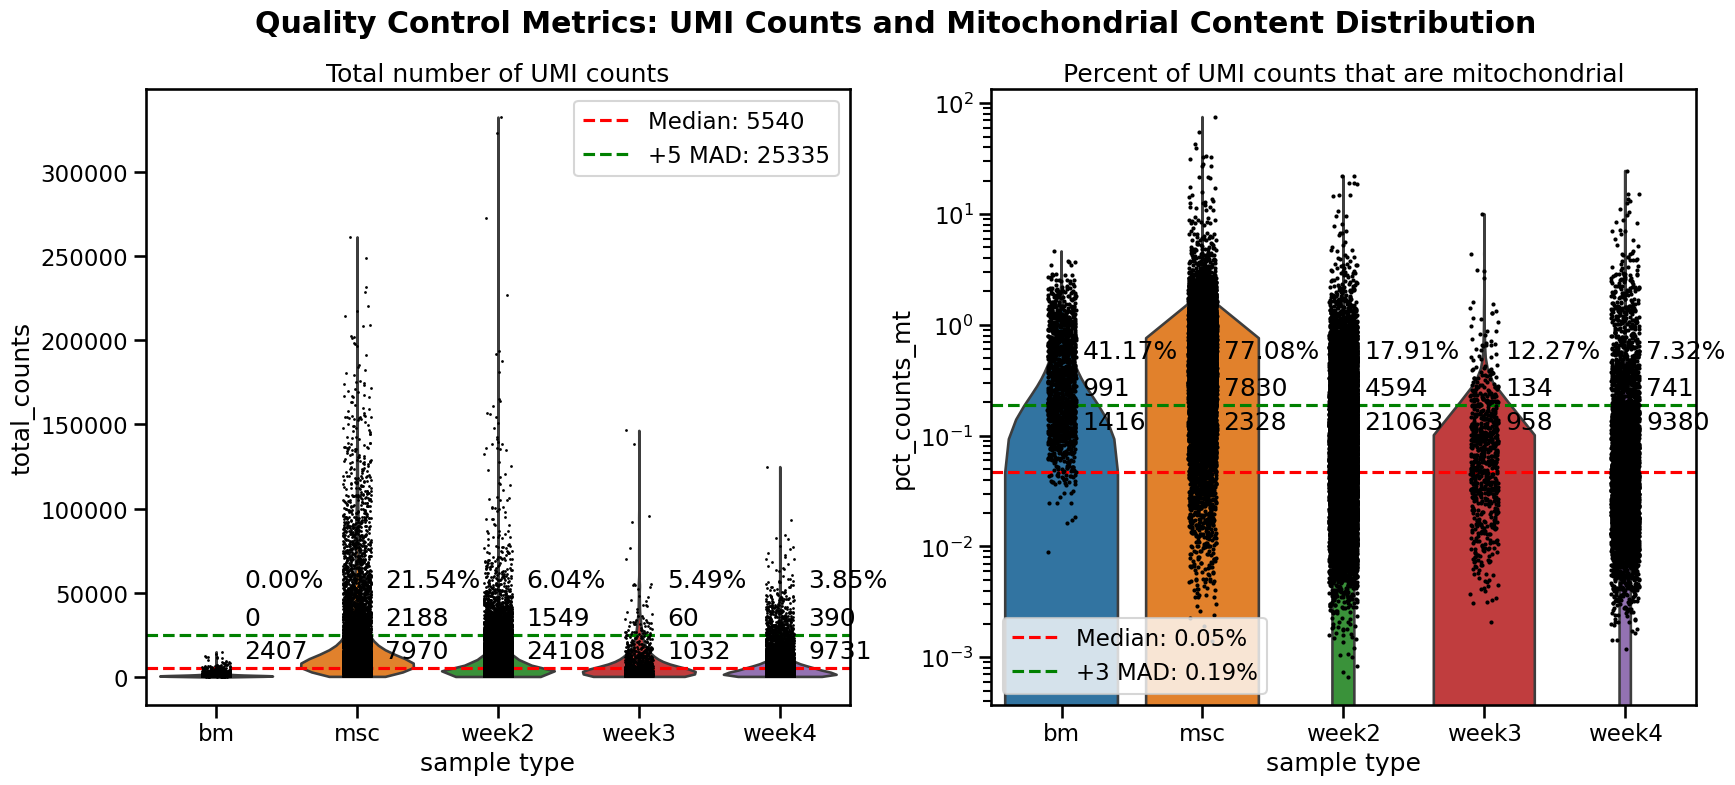

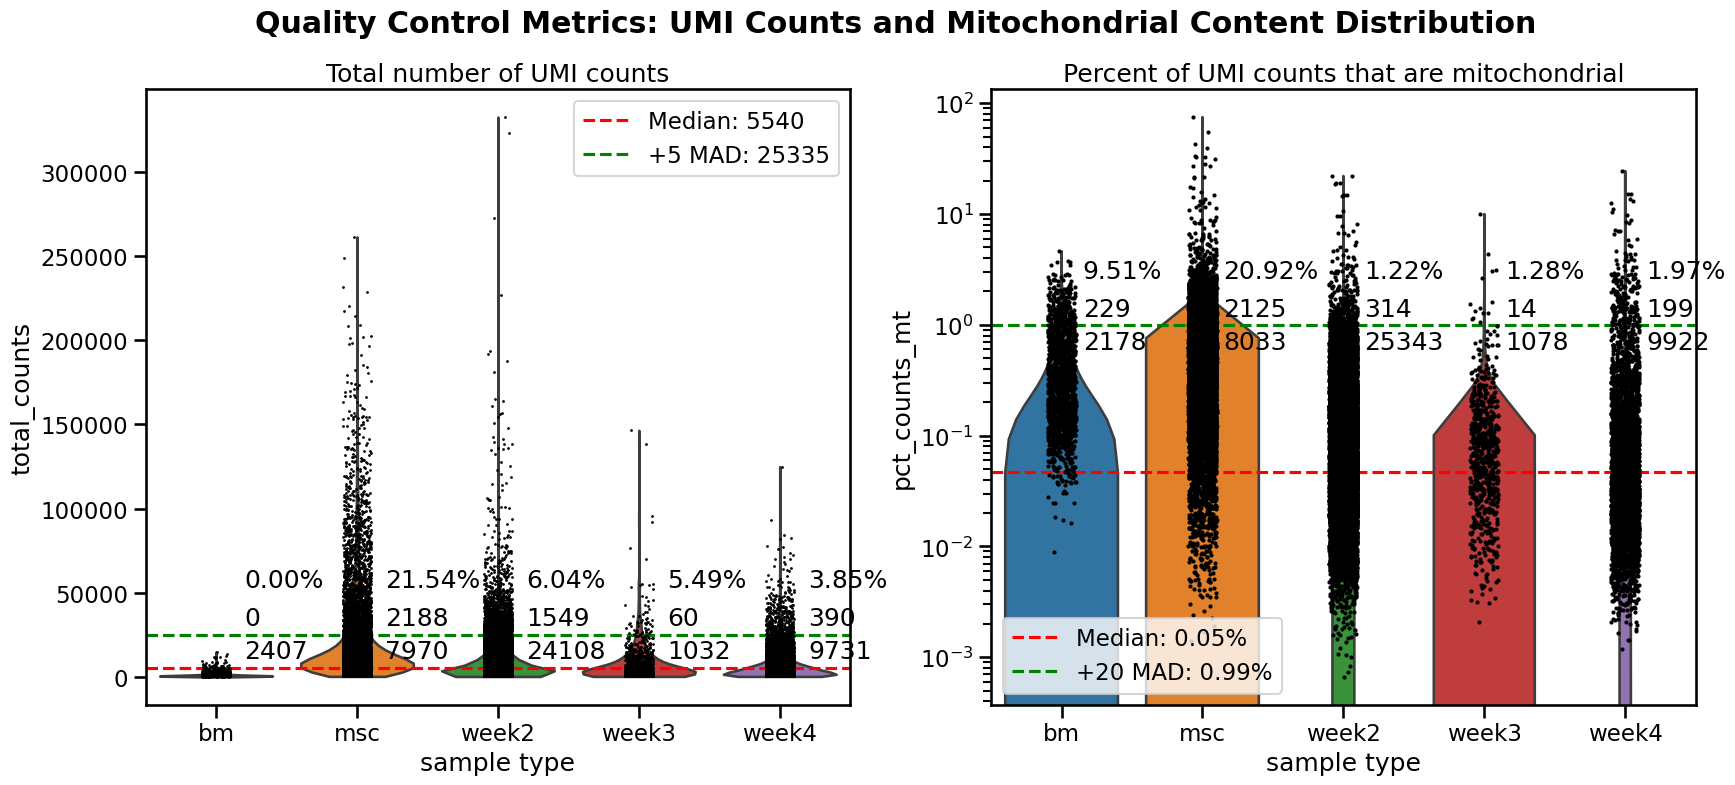

In [124]:
def plot_with_mads(adata, nmad=5, mt_nmad=3):
    fig, ax = plt.subplots(1, 2, figsize=(20, 8), gridspec_kw={'wspace': 0.2, 'width_ratios': [2, 2]})
    
    # QC calculations
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))
    
    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )
    
    # Total counts plot and thresholds
    sc.pl.violin(
        adata,
        "total_counts",
        groupby="sample_type",
        show=False,
        ax=ax[0],
        size=2
    )

    ax[0].set_title("Total number of UMI counts")
    
    counts_M = adata.obs["total_counts"]
    counts_median = np.median(counts_M)
    counts_mad = median_abs_deviation(counts_M)
    counts_upper_bound = counts_median + nmad * counts_mad
    
    ax[0].axhline(y=counts_median, color='red', linestyle='--', label=f'Median: {counts_median:.0f}')
    ax[0].axhline(y=counts_upper_bound, color='green', linestyle='--', label=f'+{nmad} MAD: {counts_upper_bound:.0f}')
    ax[0].legend()
    
    # Add counts annotations for total counts
    sample_types = ['bm', 'msc', 'week2', 'week3', 'week4']
    for idx, sample in enumerate(sample_types):
        sample_cells = adata.obs[adata.obs['sample_type'] == sample]
        above_count = np.sum(sample_cells['total_counts'] > counts_upper_bound)
        below_count = len(sample_cells) - above_count
        
        # Add text for cells above MAD
        ax[0].text(idx + 0.2, counts_upper_bound * 1.1, 
                  f'{above_count}', ha='left', va='bottom')

        # Add text for percentage of cells above MAD
        ax[0].text(idx + 0.2, counts_upper_bound * 2, 
                  f'{(above_count/len(sample_cells) * 100):.2f}%', ha='left', va='bottom')
        
        # Add text for cells below MAD
        ax[0].text(idx + 0.2, counts_upper_bound * 0.9, 
                  f'{below_count}', ha='left', va='top')
    
    # MT percent plot and thresholds
    sc.pl.violin(
        adata,
        "pct_counts_mt",
        groupby="sample_type",
        show=False,
        ax=ax[1],
        size=3,
        log=True
    )

    ax[1].set_title("Percent of UMI counts that are mitochondrial")
    
    mt_M = adata.obs["pct_counts_mt"]
    mt_median = np.median(mt_M)
    mt_mad = median_abs_deviation(mt_M)
    mt_upper_bound = mt_median + mt_nmad * mt_mad
    
    ax[1].axhline(y=mt_median, color='red', linestyle='--', label=f'Median: {mt_median:.2f}%')
    ax[1].axhline(y=mt_upper_bound, color='green', linestyle='--', label=f'+{mt_nmad} MAD: {mt_upper_bound:.2f}%')
    ax[1].legend()
    
    # Add counts annotations for MT percent
    for idx, sample in enumerate(sample_types):
        sample_cells = adata.obs[adata.obs['sample_type'] == sample]
        above_mt = np.sum(sample_cells['pct_counts_mt'] > mt_upper_bound)
        below_mt = len(sample_cells) - above_mt
        
        # Add text for cells above MAD
        ax[1].text(idx + 0.15, mt_upper_bound * 1.1, 
                  f'{above_mt}', ha='left', va='bottom')

        # Add text for percentage of cells above MAD
        ax[1].text(idx + 0.15, mt_upper_bound * 2.4, 
                  f'{(above_mt/len(sample_cells) * 100):.2f}%', ha='left', va='bottom')
        
        # Add text for cells below MAD
        ax[1].text(idx + 0.15, mt_upper_bound * 0.9, 
                  f'{below_mt}', ha='left', va='top')
    
    plt.tight_layout()

    fig.suptitle("Quality Control Metrics: UMI Counts and Mitochondrial Content Distribution", y=0.98, weight='bold')

plot_with_mads(raw_adata)
plot_with_mads(raw_adata, mt_nmad=20)

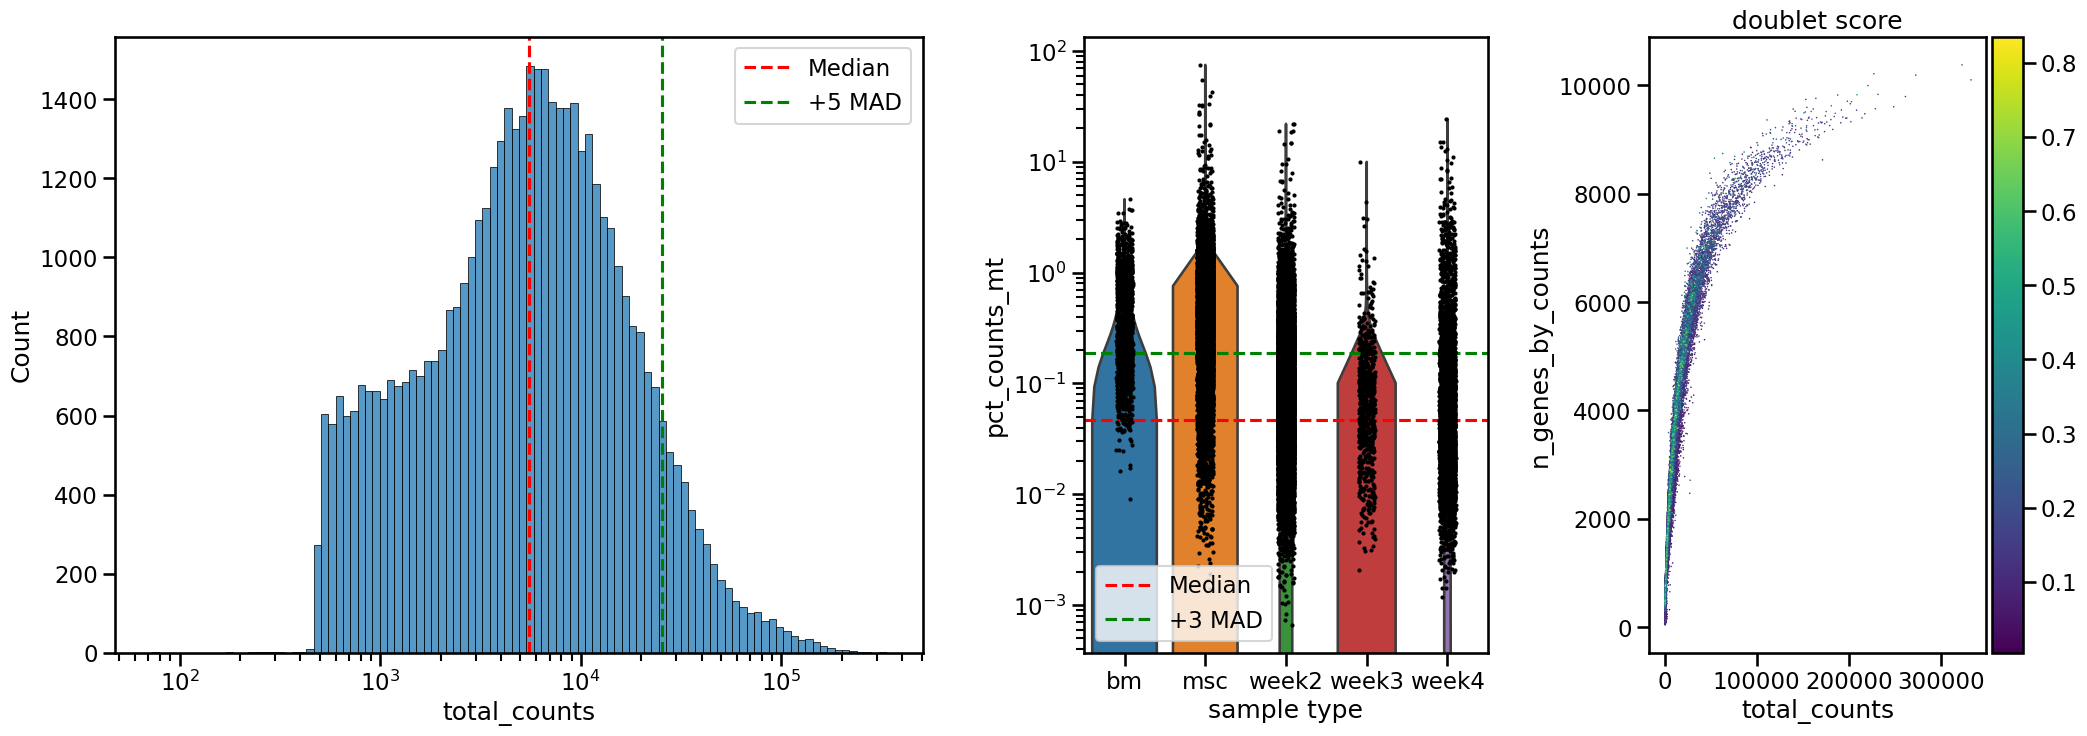

In [150]:
def plot_with_mads(adata, nmad=5, mt_nmad=3):
    
    fig, ax = plt.subplots(1, 3, figsize=(25, 8), 
                          gridspec_kw={'width_ratios': [2, 1, 1], 'wspace': 0.3})

    adata.var["mt"] = adata.var_names.str.startswith("MT-")                 # mitochondrial genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes

    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )
    
    # Calculate MAD thresholds
    counts_M = adata.obs["total_counts"]
    counts_median = np.median(counts_M)
    counts_mad = median_abs_deviation(counts_M)
    
    # Plot histogram with MAD thresholds
    sns.histplot(
        data=counts_M,
        bins=100,
        kde=False,
        ax=ax[0],
        log_scale=True
    )
    
    # Add vertical lines for median and MAD thresholds
    ax[0].axvline(x=counts_median, color='red', linestyle='--', label='Median')

    count_upper_bound = counts_median + nmad * counts_mad
    ax[0].axvline(x=count_upper_bound, color='green', linestyle='--', label=f'+{nmad} MAD')

    ax[0].legend()
    
    # Violin plot
    sc.pl.violin(
        adata,
        "pct_counts_mt",
        groupby="sample_type",
        show=False,
        ax=ax[1],
        size=3,
        log=True
    )

    mt_M = adata.obs["pct_counts_mt"]
    mt_median = np.median(mt_M)
    mt_mad = median_abs_deviation(mt_M)
    
    ax[1].axhline(y=mt_median, color='red', linestyle='--', label='Median')
    
    mt_upper_bound = mt_median + mt_nmad * mt_mad
    ax[1].axhline(y=mt_upper_bound, color='green', linestyle='--', label=f'+{mt_nmad} MAD')

    ax[1].legend()
    
    # Scatter plot
    scatter = sc.pl.scatter(
        adata,
        "total_counts",
        "n_genes_by_counts",
        color="doublet_score",
        show=False,
        ax=ax[2],
        size=5
    )
    
    # Clear existing colorbar and add new one
    ax[2].collections[0].colorbar.remove()
    plt.colorbar(ax[2].collections[0], ax=ax[2], pad=0.015)
    
    plt.show()

plot_with_mads(raw_adata)

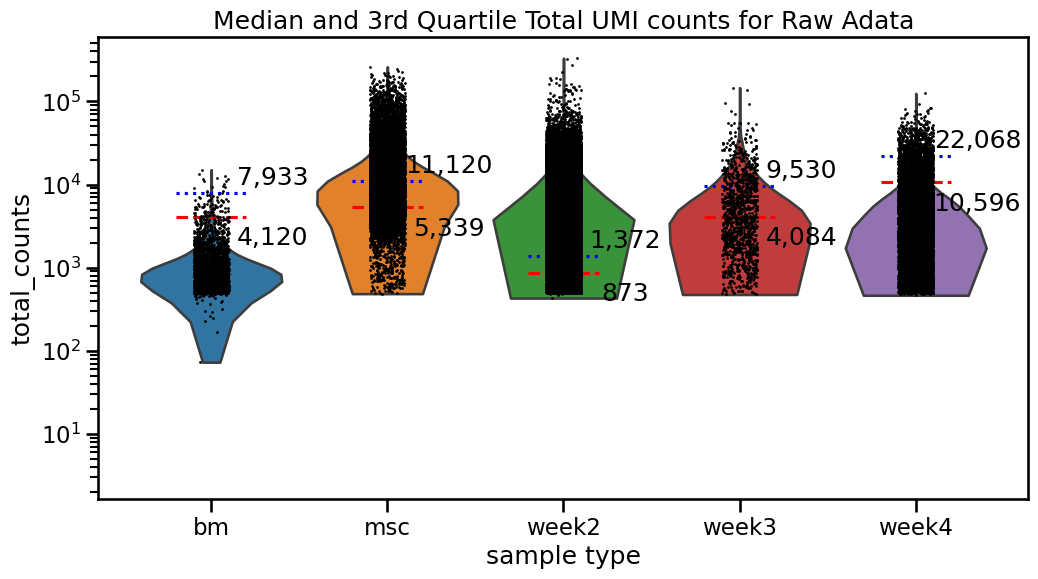

In [203]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sc.pl.violin(
    raw_adata,
    "total_counts",
    groupby="sample_type",
    show=False,
    ax=ax,
    size=2,
    log=True
)

ax.set_title("Median and 3rd Quartile Total UMI counts for Raw Adata")

samples = list(raw_adata.obs['sample_type'].unique())

# Calculate medians and quartiles
stats = {}
for name in samples:
    sample_data = raw_adata[raw_adata.obs['sample_type'] == name].obs['total_counts']
    stats[name] = {
        'median': np.median(sample_data),
        'q3': np.percentile(sample_data, 75)
    }

violin_pos = range(len(samples))
for pos, sample in zip(violin_pos, samples):
    
    # Add median line and label
    median = stats[sample]['median']
    ax.hlines(y=median, xmin=pos-0.2, xmax=pos+0.2, color='red', linestyle='--')
    ax.text(x=pos + 0.35, y=median + (median * -0.6), s=f'{median:,.0f}', ha='center', va='bottom')

    # Add Q3 line and label
    q3 = stats[sample]['q3']
    ax.hlines(y=q3, xmin=pos-0.2, xmax=pos+0.2, color='blue', linestyle=':')
    ax.text(x=pos + 0.35, y=q3 + (q3 * 0.1), s=f'{q3:,.0f}', ha='center', va='bottom')

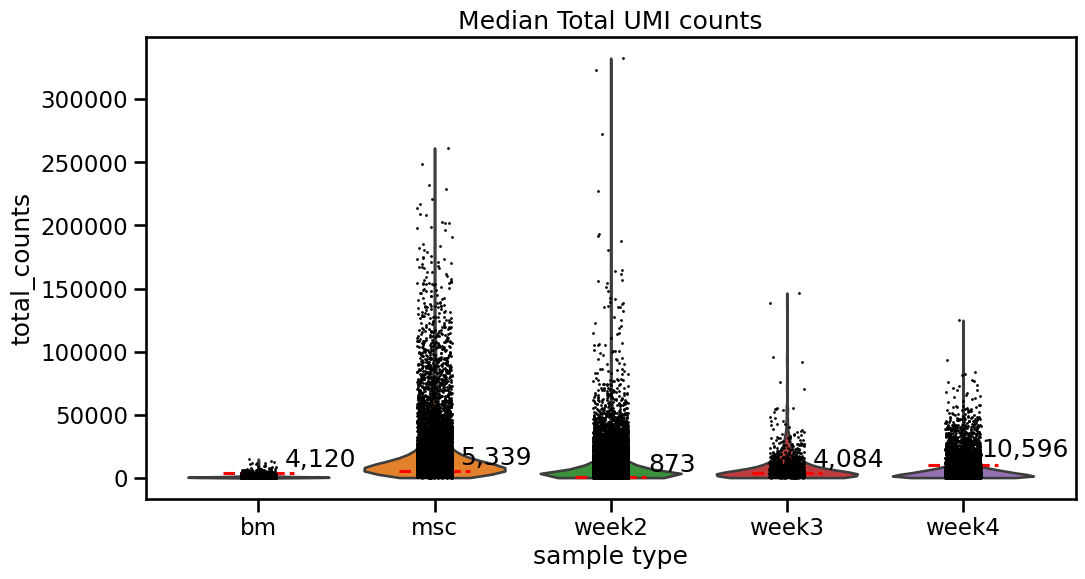

In [189]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
sc.pl.violin(
    raw_adata,
    "total_counts",
    groupby="sample_type",
    show=False,
    ax=ax,
    size=2
)

ax.set_title("Median Total UMI counts")

samples = list(raw_adata.obs['sample_type'].unique())

count_medians = {
    name: np.median(raw_adata[raw_adata.obs['sample_type'] == name].obs['total_counts'])
    for name in samples
}

violin_pos = range(len(samples))

for pos, sample in zip(violin_pos, samples):
    median = count_medians[sample]
    ax.hlines(y=median, xmin=pos-0.2, xmax=pos+0.2, color='red', linestyle='--')
    ax.text(x=pos + 0.35, y=median + (median * 0.2), s=f'{median:,.0f}', ha='center', va='bottom')

# PCA of QC metrics

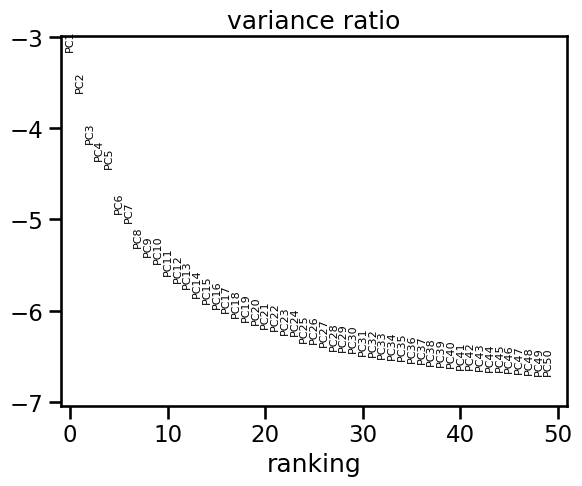

In [117]:
sc.pl.pca_variance_ratio(raw_p_adata, n_pcs=50, log=True)

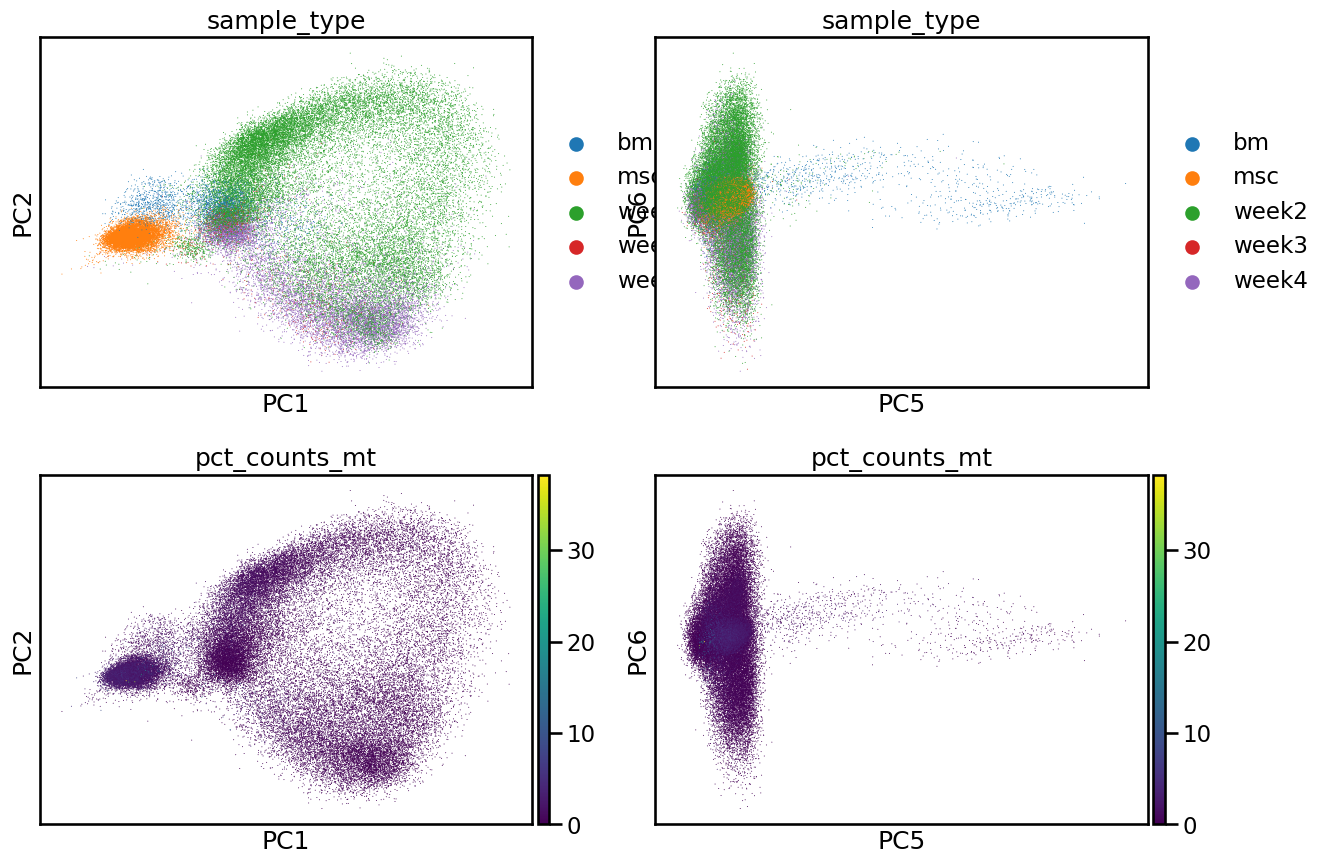

In [118]:
sc.pl.pca(
    raw_p_adata,
    color=["sample_type", "sample_type", "pct_counts_mt", "pct_counts_mt"],
    dimensions=[(0, 1), (4, 5), (0, 1), (4, 5)],
    ncols=2,
    size=2,
)

# UMAP of raw adata without filtering or processing

In [63]:
from scipy.stats import median_abs_deviation

def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (np.median(M) + nmads * median_abs_deviation(M) < M)
    
    return outlier


def raw_processing(file_path):
    
    adata.var["mt"] = adata.var_names.str.startswith("MT-")                 # mitochondrial genes
    adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))      # ribosomal genes
    adata.var["hb"] = adata.var_names.str.contains(("^HB[^(P)]"))           # hemoglobin genes

    sc.pp.calculate_qc_metrics(
        adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
    )
    
    adata.obs["outlier"] = (
        is_outlier(adata, "log1p_total_counts", 5)
        | is_outlier(adata, "log1p_n_genes_by_counts", 5)
        | is_outlier(adata, "pct_counts_in_top_20_genes", 5)
    )
    
    adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 3) | (
        adata.obs["pct_counts_mt"] > 8
    )
    
    # print(f"Total number of cells: {adata.n_obs}")
    # adata = adata[adata.obs["predicted_doublet"] == False].copy()
    # adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()
    
    # print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")
    
    # Store raw counts
    adata.layers["counts"] = adata.X.copy()
    
    # Normalizing to median total counts
    sc.pp.normalize_total(adata)
    
    # Logarithmize the data
    sc.pp.log1p(adata)
    
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.25)

    # Save raw
    adata.raw = adata
    adata = adata[:, adata.var_names[adata.var['highly_variable']]].copy()
    
    # Scale the data
    sc.pp.scale(adata, max_value=10, zero_center=False)
    
    # Perform PCA
    sc.tl.pca(adata, svd_solver='arpack')
    # adata.obsm['X_pca_temp'] = adata.obsm['X_pca']

    # # Harmonizing data based on sample type
    # X = adata.obsm['X_pca'].astype(np.float64)
    # harmony_out = hm.run_harmony(X, adata.obs, 'sample_type')
    # adata.obsm['X_pca'] = harmony_out.Z_corr.T

    # Compute neighbors and UMAP
    sc.pp.neighbors(adata, n_neighbors=50, use_rep='X_pca', n_pcs=20)
    sc.tl.umap(adata, min_dist=0.45, random_state=0, n_components=2)

    # Computing a range of leiden resolutions from 0-2 in increments of 0.2
    res_range = np.round(np.arange(0, 2.2, 0.2), 1)
    for res in res_range:
        sc.tl.leiden(
            adata, 
            flavor="igraph",
            key_added=f"leiden_{str(res).replace('.', '_')}",
            n_iterations=2,
            resolution=res
        )
    
    # sc.tl.rank_genes_groups(adata, 'leiden', method='t-test', key_added = "t-test")
    
    return adata

In [64]:
adata = raw_processing(adata).copy()

adata.write(wdir + '/rerun_objects/raw_processed_adata.h5ad', compression='gzip')

In [83]:
adata

AnnData object with n_obs × n_vars = 32845 × 4197
    obs: 'doublet_score', 'predicted_doublet', 'sample', 'base_sample', 'sample_type', 'name', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden_0_0', 'leiden_0_1', 'leiden_0_2', 'leiden_0_3', 'leiden_0_4', 'leiden_0_5', 'leiden_0_6', 'leiden_0_7', 'leiden_0_8', 'leiden_0_9', 'leiden_1_0', 'leiden_1_1', 'leiden_1_2', 'leiden_1_3', 'leiden_1_4', 'leiden_1_5', 'leiden_1_6', 'leiden_1_7', 'leiden_1_8', 'leiden_1_9', 'leiden_2_0', 'leiden_2_1'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'd

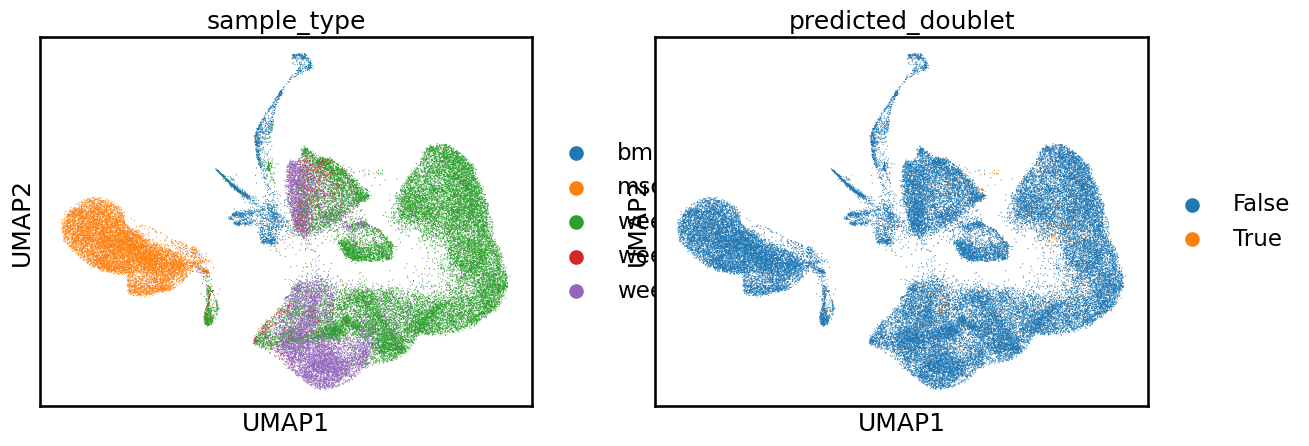

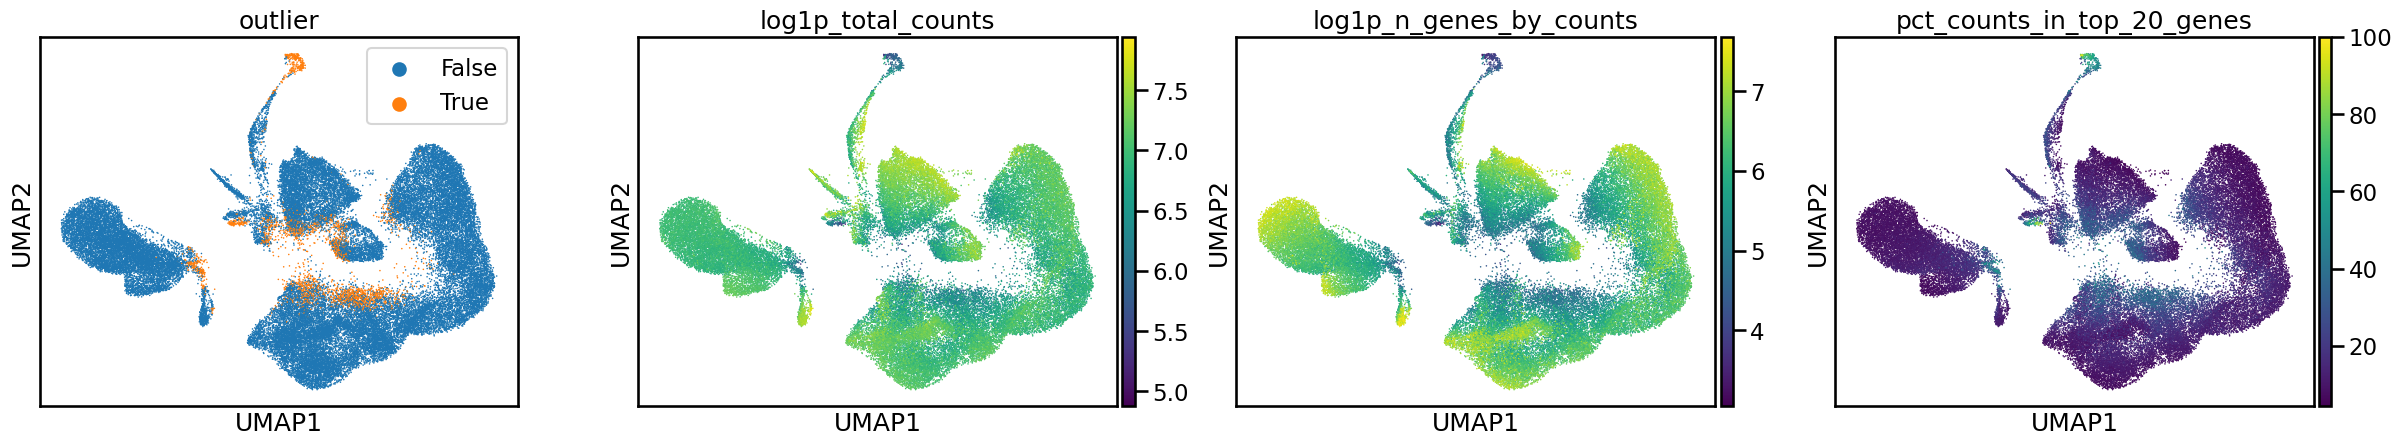

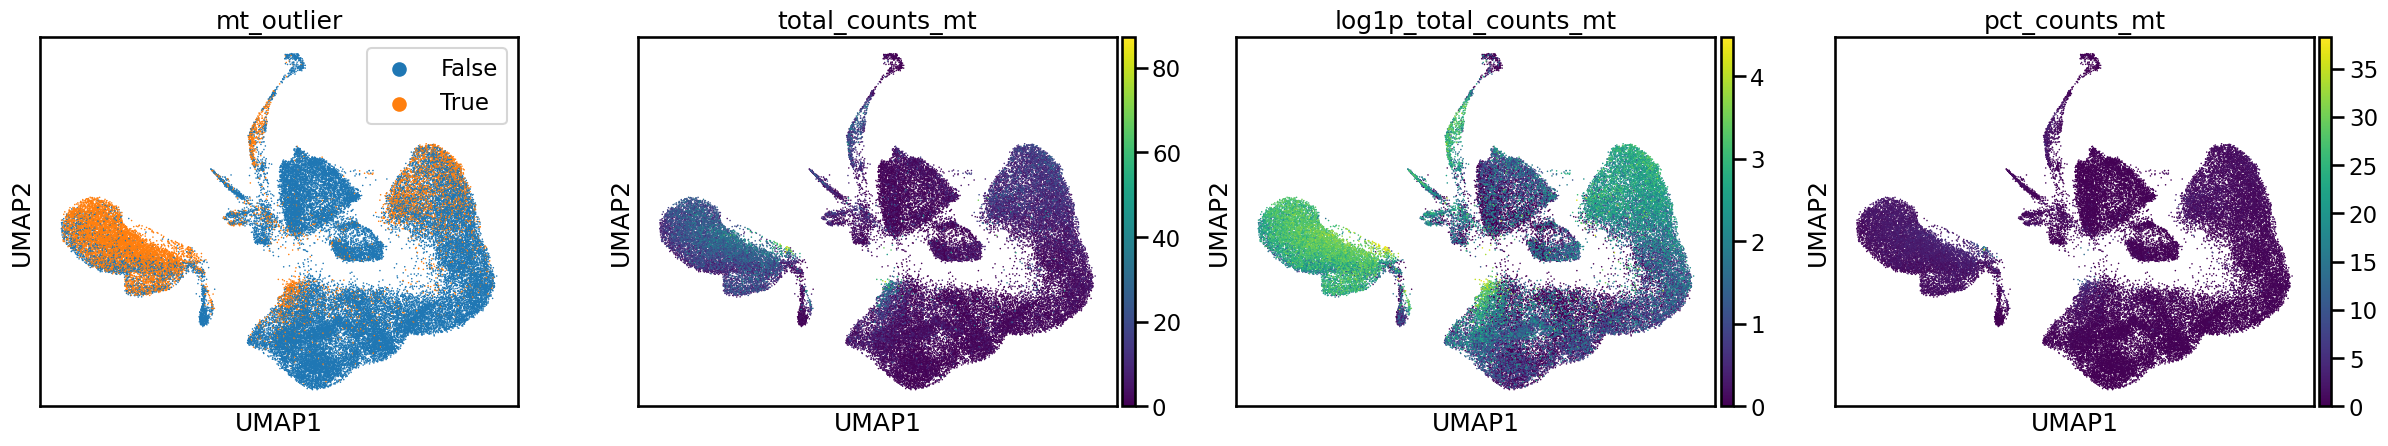

In [107]:
sc.pl.umap(
    raw_p_adata,
    color=['sample_type', 'predicted_doublet']
)

sc.pl.umap(
    raw_p_adata,
    color=['outlier', 'log1p_total_counts', 'log1p_n_genes_by_counts', 'pct_counts_in_top_20_genes'],
    legend_loc='best',
    size=5,
    sort_order=True
)

sc.pl.umap(
    raw_p_adata,
    color=['mt_outlier', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'],
    legend_loc='best',
    size=5,
    sort_order=True
)

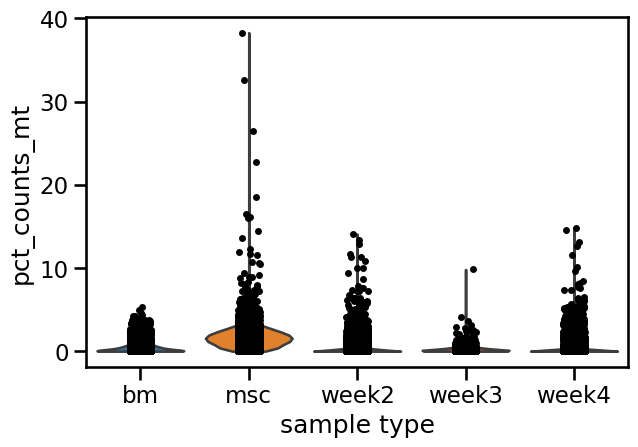

In [122]:
sc.pl.violin(raw_p_adata, 'pct_counts_mt', groupby='sample_type', size=5)